# MEG/EEG Event‑Related Pipeline (with ASR)

**Goal:** Load MEG/EEG data, clean it with Artifact Subspace Reconstruction (ASR), detect stimulus events, extract time‑locked epochs, and visualize the averaged evoked response.

## 1) Imports & Versions

We import the core scientific stack and specialized MEG/EEG tooling. `mne` handles data structures and processing; `meegkit` provides ASR for artifact removal.

In [1]:
import numpy as np
import mne
from mne.datasets import sample
from pathlib import Path
from meegkit.asr import ASR
from meegkit.utils.matrix import sliding_window

print("MNE:", mne.__version__)
try:
    import meegkit
    print("meegkit:", meegkit.__version__)
except Exception:
    print("meegkit present (version print may require import as module)")

MNE: 1.10.1
meegkit: 0.1.9


## 2) What data are we using?

**Dataset:** MNE‑Python’s built‑in *sample* dataset. It contains simultaneous MEG+EEG from a volunteer who received **auditory tones** (left/right ear) and **visual checkerboard** flashes (left/right field). A dedicated *stimulus channel* stores integer **trigger codes** that mark when each stimulus occurred.

Why this matters:
- MEG/EEG are fast but noisy. We’ll reduce noise (filtering + ASR) and then align data to stimulus times (event detection → epochs → average) to reveal reliable brain responses.

## 3) Load raw data

We read the continuous recording (time series for each sensor) into memory.

In [2]:
# 1. Load Raw data
raw = mne.io.read_raw_fif(
    sample.data_path() / 'MEG' / 'sample' / 'sample_audvis_filt-0-40_raw.fif',
    preload=True,
)
raw

Opening raw data file /home/alex/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Reading 0 ... 41699  =      0.000 ...   277.709 secs...


<Raw | sample_audvis_filt-0-40_raw.fif, 376 x 41700 (277.7 s), ~122.8 MiB, data loaded>

**Why:** Having the full dataset in memory (`preload=True`) lets us filter and clean efficiently.


## 4) Band‑pass filtering (1–40 Hz)

We keep frequencies typical of evoked responses and drop very slow drifts and high‑frequency noise.

- **1 Hz** high‑pass: removes slow drifts and sweat/electrode trends.
- **40 Hz** low‑pass: reduces muscle noise and line‑related harmonics.

In [3]:
# 2. Preprocess: filter & mark bads
raw.filter(1., 40., fir_design='firwin')
raw.info['bads'] = []  # placeholder if you need to flag noisy sensors later

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 497 samples (3.310 s)



**Why:** Cleaning the spectrum improves SNR and helps the ASR step and later averaging.


## 5) Prepare data for ASR (stable normalization)

ASR expects reasonably scaled channels. We compute per‑channel standard deviations, guard against zeros, and normalize.

In [4]:
# 3. Prepare data with stable variance
data = raw.get_data()                 # shape: (n_channels, n_times)
stds = np.std(data, axis=1, keepdims=True)
stds[stds == 0] = 1e-10               # avoid division by zero
data_stable = data / stds             # normalize channel scales
sfreq = raw.info['sfreq']             # sampling frequency (Hz)

**Why:** Prevents numerical problems (e.g., divide‑by‑zero) and keeps ASR thresholds meaningful across channels.

## 6) Artifact Subspace Reconstruction (ASR)

ASR learns a model of "clean" activity from a calibration window, then attenuates transient, high‑variance artifacts (movement, muscle, brief sensor glitches) in a **sliding window** manner.

- **Calibration window:** We’ll use the first 30 s (adjust if the beginning is noisy).
- **Sliding windows:** Process 1‑second chunks (non‑overlapping for simplicity) and stitch back together.

In [5]:
# 4. Apply ASR safely
asr = ASR(sfreq=sfreq, method='euclid')
calib_idx = np.arange(0, int(30 * sfreq), dtype=int)  # first 30 seconds

# Fit ASR on calibration data (suppress benign warnings about numerical edges)
with np.errstate(divide='ignore', invalid='ignore'):
    _, sample_mask = asr.fit(data_stable[:, calib_idx])

# Transform full recording in 1-second windows
X = sliding_window(data_stable, window=int(sfreq), step=int(sfreq))
Y = np.zeros_like(X)
for i in range(X.shape[1]):
    with np.errstate(divide='ignore', invalid='ignore'):
        Y[:, i, :] = asr.transform(X[:, i, :])

clean_data = Y.reshape(data.shape)

# Put cleaned data back into an MNE Raw object, preserving metadata
raw_clean = raw.copy()
raw_clean._data = clean_data
raw_clean

<Raw | sample_audvis_filt-0-40_raw.fif, 376 x 41700 (277.7 s), ~122.8 MiB, data loaded>

**Why:** ASR reduces non‑brain transients without hand‑tuning. Sliding windows keep the method robust across time.

**Notes:** If the first 30 s are not clean, pick a different calibration range. You can also use overlapping windows for smoother transitions.

## 7) Detect stimulus events (triggers)

The dataset contains a special trigger channel (often `STI 014`). We detect time points where the trigger code changes.

Parameters:
- `shortest_event=1`: allow brief but valid one‑sample triggers.
- `min_duration=1./sfreq`: enforces a minimal time width (one sample) to avoid spurious blips.
- `uint_cast=True`: fixes signed/unsigned quirks in some MEG systems so codes aren’t misread as negative.

In [6]:
# 5. Event detection with uint_cast
events = mne.find_events(
    raw_clean,
    stim_channel='STI 014',
    shortest_event=1,
    min_duration=1.0 / sfreq,
    uint_cast=True
)
print(f"{len(events)} events found (with uint_cast=True)")

Finding events on: STI 014
357 events found on stim channel STI 014
Event IDs: [    1     2     3     4    24    25    26    27    28    29 65532 65535]
357 events found (with uint_cast=True)


**Why:** Accurate event times are essential for aligning the neural response to the stimulus.


## 8) Keep only event types of interest

The sample dataset includes multiple event codes (auditory left/right, visual left/right, etc.). Here we restrict analysis to a subset (codes `1` and `3`) for clarity.

In [7]:
# 6. Filter to relevant codes
desired = [1, 3]
events = events[np.isin(events[:, 2], desired)]
print(f"{len(events)} events retained after code filtering")

178 events retained after code filtering


**Why:** Focusing the analysis avoids mixing conditions and makes the evoked response easier to interpret.


## 9) Create epochs and average (evoked)

We extract windows from **–200 ms to +500 ms** around each event, correct the baseline using the pre‑stimulus period, and then average across trials to enhance the consistent signal.

Not setting metadata
178 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 4)
4 projection items activated
Using data from preloaded Raw for 178 events and 106 original time points ...
0 bad epochs dropped


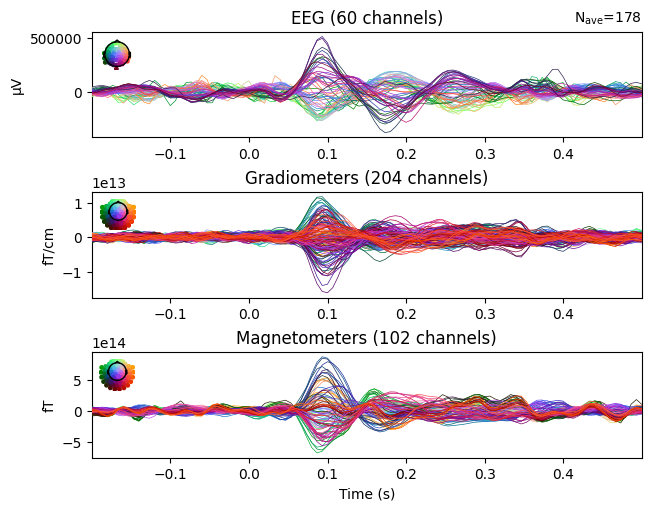

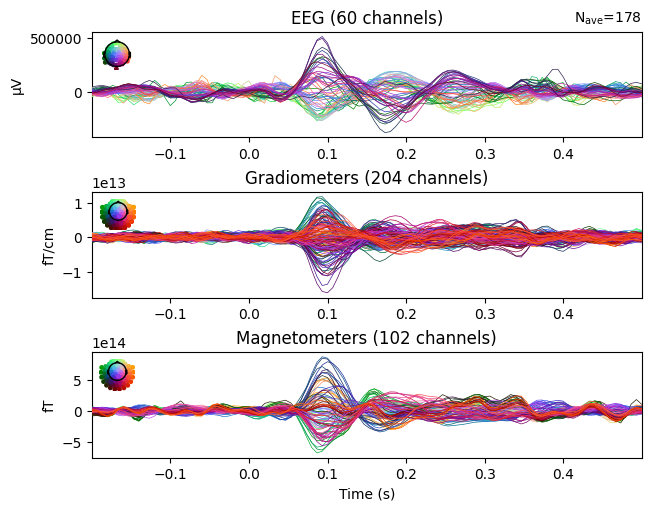

In [8]:
# Continue with epochs
epochs = mne.Epochs(
    raw_clean, events, event_id=dict(auditory=1, visual=3),
    tmin=-0.2, tmax=0.5, baseline=(None, 0),
    preload=True, reject_by_annotation=True
)
evoked = epochs.average()
evoked.plot()

**Why:** Averaging across many trials boosts the true, time‑locked brain response (evoked potential/field) while canceling random noise.

**Interpretation tips:**
- Time axis (x): milliseconds relative to stimulus onset (0 ms).
- Amplitude (y): sensor signal strength. Peaks around ~100 ms are typical for early sensory processing.

## 10) Where to go next

- **Quality checks:** Plot power spectral density (PSD) before/after ASR; inspect raw vs. cleaned traces.
- **Compare conditions:** Split epochs by code and plot separate evokeds (e.g., code 1 vs. 3).
- **Decoding:** Use `mne.decoding` + scikit‑learn to classify stimulus identity from sensor data.
- **Source localization:** Build a forward model and compute inverse solutions (e.g., dSPM) to estimate cortical sources.

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 13.639 (s)
Plotting power spectral density (dB=True).
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 13.639 (s)
Plotting power spectral density (dB=True).


/home/alex/.venvs/jupyter_env/lib/python3.12/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
/home/alex/.venvs/jupyter_env/lib/python3.12/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


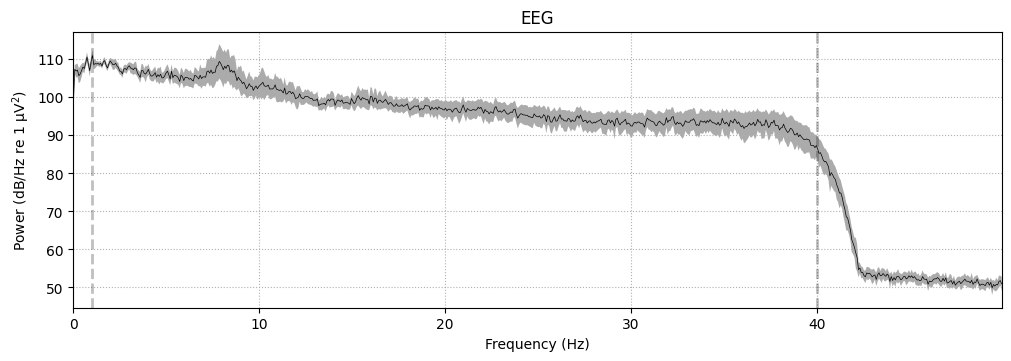

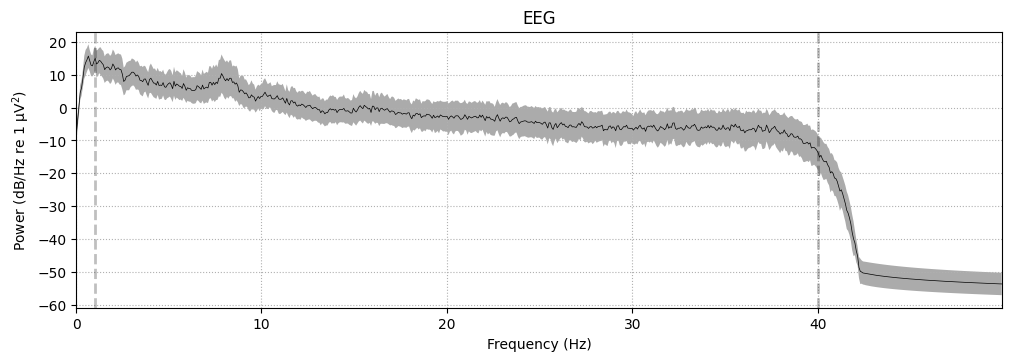

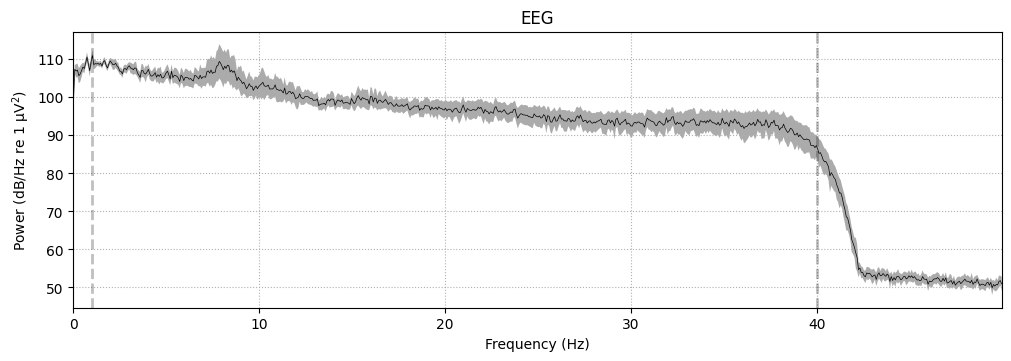

In [9]:
# 10a. Quality checks: PSD before vs after ASR
raw.plot_psd(fmax=50, average=True, picks="eeg")
raw_clean.plot_psd(fmax=50, average=True, picks="eeg")

Multiple channel types selected, returning one figure per type.
combining channels using RMS (grad channels)
combining channels using RMS (grad channels)


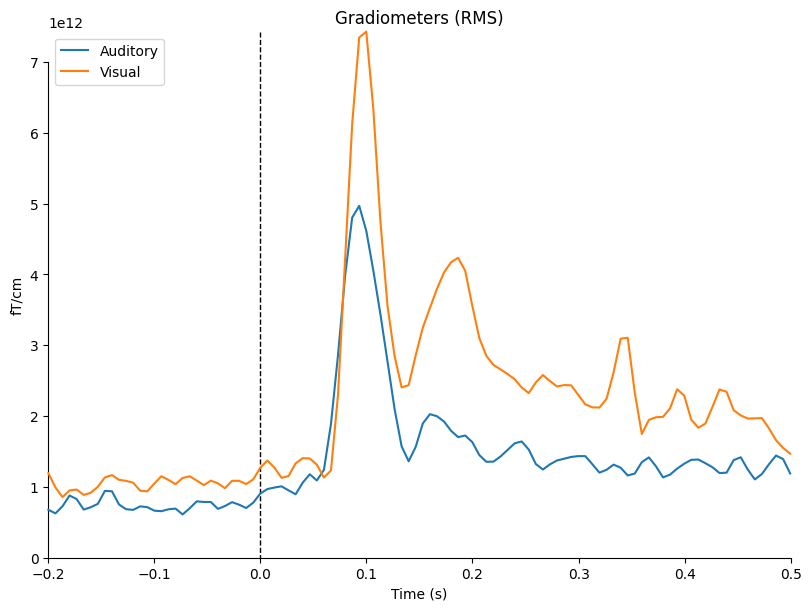

combining channels using RMS (mag channels)
combining channels using RMS (mag channels)


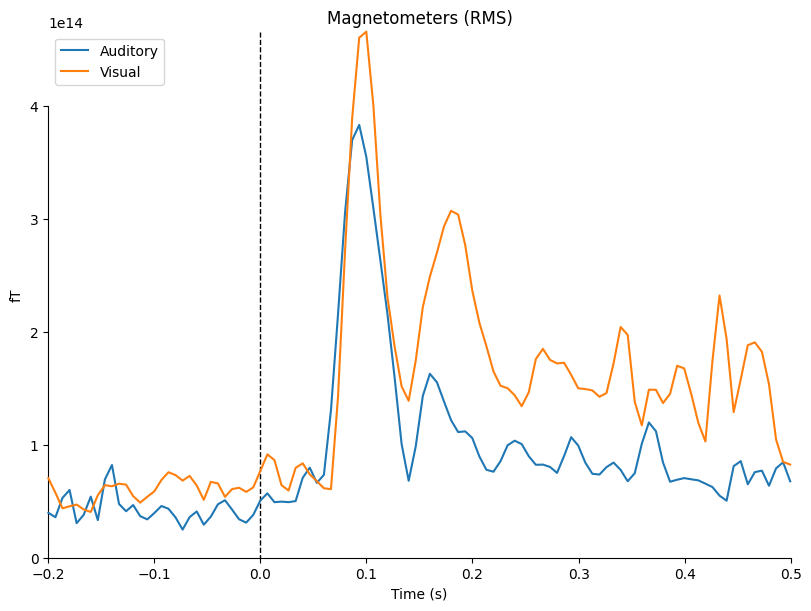

combining channels using GFP (eeg channels)
combining channels using GFP (eeg channels)


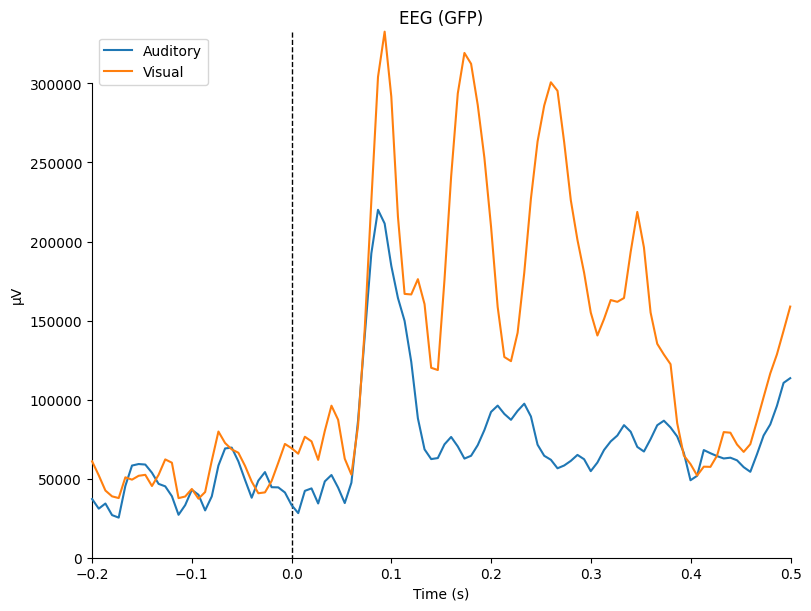

[<Figure size 800x600 with 1 Axes>,
 <Figure size 800x600 with 1 Axes>,
 <Figure size 800x600 with 1 Axes>]

In [10]:
# 10b. Compare conditions separately
evoked_auditory = epochs["auditory"].average()
evoked_visual = epochs["visual"].average()

mne.viz.plot_compare_evokeds(
    dict(Auditory=evoked_auditory, Visual=evoked_visual),
    combine='mean')

In [11]:
# 10c. Simple decoding example (classification)
from mne.decoding import CSP
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

X = epochs.get_data()  # shape: (n_epochs, n_channels, n_times)
y = epochs.events[:, 2]  # labels (1=auditory, 3=visual)

clf = make_pipeline(
    CSP(n_components=4, reg=None, log=True, norm_trace=False),
    LogisticRegression(max_iter=1000)
)

cv = StratifiedKFold(5, shuffle=True, random_state=42)
scores = cross_val_score(clf, X, y, cv=cv, n_jobs=1)
print("Decoding accuracy: %0.2f ± %0.2f" % (scores.mean(), scores.std()))

Computing rank from data with rank=None
    Using tolerance 58 (2.2e-16 eps * 376 dim * 7e+14  max singular value)
    Estimated rank (data): 368
    data: rank 368 computed from 376 data channels with 0 projectors
    Setting small data eigenvalues to zero (without PCA)
Reducing data rank from 376 -> 368
Estimating class=1 covariance using EMPIRICAL
Done.
Estimating class=3 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 58 (2.2e-16 eps * 376 dim * 7e+14  max singular value)
    Estimated rank (data): 368
    data: rank 368 computed from 376 data channels with 0 projectors
    Setting small data eigenvalues to zero (without PCA)
Reducing data rank from 376 -> 368
Estimating class=1 covariance using EMPIRICAL
Done.
Estimating class=3 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 59 (2.2e-16 eps * 376 dim * 7.1e+14  max singular value)
    Estimated rank (data): 368
    data: rank 368 computed fr